In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [43]:
data = pd.read_csv('/content/makanan.csv')
df = pd.DataFrame(data)
df

,makanan,kenyang,sehat,rasa,bosan,harga
0,ayamgeprek,0.9,0.5,0.7,0.2,15000.0
1,nasipadang,1.0,0.8,0.9,0.5,17000.0
2,mieayam,1.0,0.6,0.9,0.3,10000.0
3,bakso,0.7,0.3,1.0,0.3,10000.0
4,cireng,0.5,0.4,0.8,0.7,10000.0
5,nasigoreng,0.8,0.7,1.0,0.5,14000.0
6,seblak,0.6,0.2,0.8,0.8,15000.0
7,gorengan,0.5,0.2,0.5,0.5,10000.0
8,capcay,0.6,0.9,0.8,0.4,15000.0
9,mi instan,0.5,0.1,0.7,0.2,5000.0


In [44]:
# Parameters
NPM = 47
np.random.seed(NPM)

SAMPLE_NUM = 500
DAYS = 31
MEALS_PER_DAY = 2


In [45]:
# @title Fungsi Simulasi

def simulate(makan, seed=NPM, sample_num=SAMPLE_NUM, days=DAYS, meals_per_day=MEALS_PER_DAY):
    np.random.seed(seed)
    SISA_MININUM = 150_000
    SISA_MAKSIMUM = 300_000
    bin_sisa = np.arange(SISA_MININUM, SISA_MAKSIMUM, 1000)

    sampleid = np.arange(sample_num)
    skor = np.zeros(sample_num, dtype=np.double)
    sisa = np.zeros(sample_num, dtype=np.double)
    sehat = np.zeros(sample_num, dtype=np.double)
    resp_sehat = np.full((sample_num, len(bin_sisa)), np.nan, dtype=np.double)
    resp_pilih = np.full((sample_num, days * meals_per_day), -1, dtype=int)

    wkenyang_base = 0.8
    wrasa_base = 0.7
    wsehat_base = 0.9
    wbosan_base = 0.2

    for n in range(sample_num):
        budget = 1e6
        skor_kumulatif = 0.0
        skor_sehat = 0.0
        for i in range(days):
            # pagi
            pilihan = np.random.randint(0, len(makan))
            w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
            w_rasa = np.random.normal(loc=wrasa_base, scale=0.2)
            w_sehat = np.random.normal(loc=wsehat_base, scale=0.4)
            w_bosan = np.random.normal(loc=wbosan_base, scale=0.2)
            k_val = makan['kenyang'].iloc[pilihan]
            r_val = makan['rasa'].iloc[pilihan]
            s_val = makan['sehat'].iloc[pilihan]
            b_val = makan['bosan'].iloc[pilihan]
            h_val = makan['harga'].iloc[pilihan]
            skor_kumulatif += w_kenyang * k_val + w_rasa * r_val + w_sehat * s_val - w_bosan * b_val
            skor_sehat += s_val - 0.5
            budget -= h_val
            resp_pilih[n][2*i] = pilihan

            # malam
            pilihan = np.random.randint(0, len(makan))
            w_kenyang = np.random.normal(loc=wkenyang_base, scale=0.2)
            w_rasa = np.random.normal(loc=wrasa_base, scale=0.2)
            w_sehat = np.random.normal(loc=wsehat_base + 0.2, scale=0.4)
            w_bosan = np.random.normal(loc=wbosan_base * 2, scale=0.2)
            k_val = makan['kenyang'].iloc[pilihan]
            r_val = makan['rasa'].iloc[pilihan]
            s_val = makan['sehat'].iloc[pilihan]
            b_val = makan['bosan'].iloc[pilihan]
            h_val = makan['harga'].iloc[pilihan]
            skor_kumulatif += w_kenyang * k_val + w_rasa * r_val + w_sehat * s_val - w_bosan * b_val
            skor_sehat += s_val - 0.5
            budget -= h_val
            resp_pilih[n][2*i + 1] = pilihan

        sisa[n] = budget
        skor[n] = skor_kumulatif
        sehat[n] = skor_sehat

        bin_index = int((budget - SISA_MININUM) / 1000)
        if 0 <= bin_index < len(bin_sisa):
            resp_sehat[n, bin_index] = skor_sehat

    return {
        'sampleid': sampleid, 'skor': skor, 'sisa': sisa, 'sehat': sehat,
        'resp_sehat': resp_sehat, 'resp_pilih': resp_pilih
    }


In [46]:
sim = simulate(makan)
print("Simulasi selesai.")
print("Contoh sisa (5):", sim['sisa'][:5])
print("Contoh skor (5):", sim['skor'][:5])
print("Contoh sehat (5):", sim['sehat'][:5])


Simulasi selesai.
Contoh sisa (5): [279000. 236000. 246000. 264000. 220000.]
Contoh skor (5): [ 93.51803827 100.19884086  90.01693377  94.66606797 100.73236748]
Contoh sehat (5): [ 3.   4.  -0.6  4.6  4.7]


In [47]:
# @title Analisis Data

resp_sehat = sim['resp_sehat']
resp_pilih = sim['resp_pilih']
sisa = sim['sisa']
sehat = sim['sehat']
skor = sim['skor']

has_positive_resp_sehat = np.array([np.any(resp_sehat[row] > 0) for row in range(len(skor))])
samples_with_pos_resp = np.where(has_positive_resp_sehat)[0]

choices_from_positive = resp_pilih[samples_with_pos_resp].flatten() if len(samples_with_pos_resp)>0 else np.array([],dtype=int)
choices_from_positive = choices_from_positive[choices_from_positive >= 0]
if choices_from_positive.size > 0:
    unique_choices, counts = np.unique(choices_from_positive, return_counts=True)
    food_freq_df = pd.DataFrame({
        'food_idx': unique_choices.astype(int),
        'count': counts,
        'food_name': [makan['makanan'].iloc[int(i)] for i in unique_choices.astype(int)]
    }).sort_values('count', ascending=False).reset_index(drop=True)
else:
    food_freq_df = pd.DataFrame(columns=['food_idx','count','food_name'])

samples_pos_health_and_sisa = [idx for idx in samples_with_pos_resp if sisa[idx] > 0]
valid_samples = np.where(sehat > 0)[0]
if len(valid_samples) > 0:
    idx_max_skor = int(valid_samples[np.argmax(skor[valid_samples])])
else:
    idx_max_skor = None

candidates_table = pd.DataFrame({
    'sample_id': np.arange(len(skor)),
    'sisa': sisa,
    'sehat': sehat,
    'skor': skor,
    'has_pos_resp_sehat': has_positive_resp_sehat
})

print("Analisis selesai.")
print("Jumlah sample dengan resp_sehat positif:", len(samples_with_pos_resp))
print("Jumlah sample dengan resp_sehat positif & sisa>0:", len(samples_pos_health_and_sisa))
print("idx_max_skor (sehat>0):", idx_max_skor)


Analisis selesai.
Jumlah sample dengan resp_sehat positif: 443
Jumlah sample dengan resp_sehat positif & sisa>0: 443
idx_max_skor (sehat>0): 78


In [48]:
# Summary
print(f"Seed (NPM): {NPM}. Simulasi: {SAMPLE_NUM} x {DAYS} hari x {MEALS_PER_DAY} makan/hari.")
print(f"Samples dengan minimal 1 bin resp_sehat positif: {len(samples_with_pos_resp)} / {SAMPLE_NUM}")
print(f"Dari itu, yang memiliki sisa>0: {len(samples_pos_health_and_sisa)}")

if idx_max_skor is not None:
    i = idx_max_skor
    print("\nSample terbaik (idx_max_skor):", i)
    print(" - Sisa akhir:", f"{sisa[i]:,.0f} Rp")
    print(" - Cumulative health (sehat):", f"{sehat[i]:.3f}")
    print(" - Cumulative preference (skor):", f"{skor[i]:.3f}")
else:
    print("\nTidak ada sample dengan sehat>0 (tidak ditemukan).")


Seed (NPM): 47. Simulasi: 500 x 31 hari x 2 makan/hari.
Samples dengan minimal 1 bin resp_sehat positif: 443 / 500
Dari itu, yang memiliki sisa>0: 443

Sample terbaik (idx_max_skor): 78
 - Sisa akhir: 218,000 Rp
 - Cumulative health (sehat): 4.600
 - Cumulative preference (skor): 106.934


In [26]:
top_candidates = candidates_table[candidates_table['has_pos_resp_sehat']].sort_values('sehat', ascending=False).head(10)
if top_candidates.empty:
    print("Tidak ada kandidat yang memenuhi kondisi.")
else:
    display(top_candidates.style.format({'sisa':'{:,}','sehat':'{:.3f}','skor':'{:.3f}'}))


,sample_id,sisa,sehat,skor,has_pos_resp_sehat
377,377,"177,000.0",9.100,105.050,True
388,388,"182,000.0",8.300,98.896,True
136,136,"189,000.0",8.300,100.093,True
454,454,"188,000.0",7.900,103.980,True
119,119,"179,000.0",7.800,104.464,True
111,111,"186,000.0",7.700,100.409,True
422,422,"201,000.0",7.700,105.239,True
446,446,"167,000.0",7.300,103.504,True
148,148,"161,000.0",6.700,100.262,True
96,96,"190,000.0",6.600,96.154,True


In [49]:
# Makanan yang paling banyak muncul
if food_freq_df.empty:
    print("Tidak ada pilihan makanan dari sample positif.")
else:
    display(food_freq_df.head(17))


,food_idx,count,food_name
0,0,1750,ayamgeprek
1,15,1744,nasi_3t
2,5,1716,nasigoreng
3,12,1656,warteg
4,8,1646,capcay
5,13,1631,nasi_campur
6,2,1628,mieayam
7,4,1625,cireng
8,1,1621,nasipadang
9,16,1608,soto_ayam


In [41]:
# @title Schedule Terbaik

if idx_max_skor is None:
    print("Tidak ada schedule — tidak ditemukan sample dengan sehat>0.")
else:
    choices_idx = sim['resp_pilih'][idx_max_skor].astype(int)
    days = list(range(1, DAYS+1))
    morning_idx = choices_idx[::2]
    evening_idx = choices_idx[1::2]
    morning_food = [makan['makanan'].iloc[i] if i>=0 else None for i in morning_idx]
    evening_food = [makan['makanan'].iloc[i] if i>=0 else None for i in evening_idx]
    morning_price = [makan['harga'].iloc[i] if i>=0 else np.nan for i in morning_idx]
    evening_price = [makan['harga'].iloc[i] if i>=0 else np.nan for i in evening_idx]
    schedule_df = pd.DataFrame({
        'Day': days,
        'Morning_food': morning_food,
        'Morning_price': morning_price,
        'Evening_food': evening_food,
        'Evening_price': evening_price
    })
    init_budget = 1e6
    cum_spent = np.cumsum([ (row['Morning_price'] if not np.isnan(row['Morning_price']) else 0) +
                             (row['Evening_price'] if not np.isnan(row['Evening_price']) else 0)
                            for _, row in schedule_df.iterrows() ])
    schedule_df['Remaining_budget_after_day'] = init_budget - cum_spent
    display(schedule_df.head(31).style.format({'Morning_price':'{:,}','Evening_price':'{:,}','Remaining_budget_after_day':'{:,}'}))


,Day,Morning_food,Morning_price,Evening_food,Evening_price,Remaining_budget_after_day
0,1,cireng,"10,000.0",mi instan,"5,000.0","985,000.0"
1,2,cireng,"10,000.0",warteg,"18,000.0","957,000.0"
2,3,roti,"3,000.0",capcay,"15,000.0","939,000.0"
3,4,nasi_campur,"15,000.0",bakso,"10,000.0","914,000.0"
4,5,nasi_campur,"15,000.0",kebab_jumbo,"10,000.0","889,000.0"
5,6,nasi_3t,"13,000.0",warteg,"18,000.0","858,000.0"
6,7,capcay,"15,000.0",soto_ayam,"17,000.0","826,000.0"
7,8,nasipadang,"17,000.0",roti,"3,000.0","806,000.0"
8,9,nasigoreng,"14,000.0",roti,"3,000.0","789,000.0"
9,10,gorengan,"10,000.0",nasi_3t,"13,000.0","766,000.0"


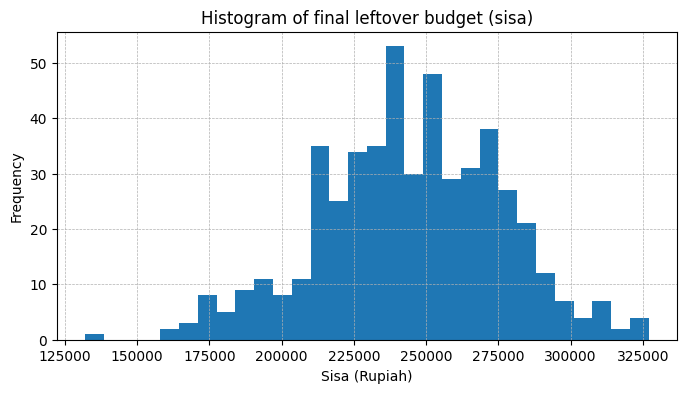

In [51]:
# Plot Histogram Sisa Budget
plt.figure(figsize=(8,4))
plt.hist(sim['sisa'], bins=30)
plt.title('Histogram of final leftover budget (sisa)')
plt.xlabel('Sisa (Rupiah)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


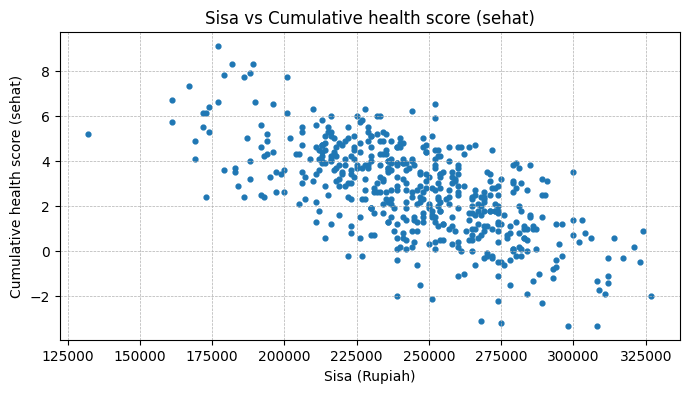

In [52]:
# Scatter Plot Sisa Budget vs Kesehatan
plt.figure(figsize=(8,4))
plt.scatter(sim['sisa'], sim['sehat'], s=12)
plt.title('Sisa vs Cumulative health score (sehat)')
plt.xlabel('Sisa (Rupiah)')
plt.ylabel('Cumulative health score (sehat)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


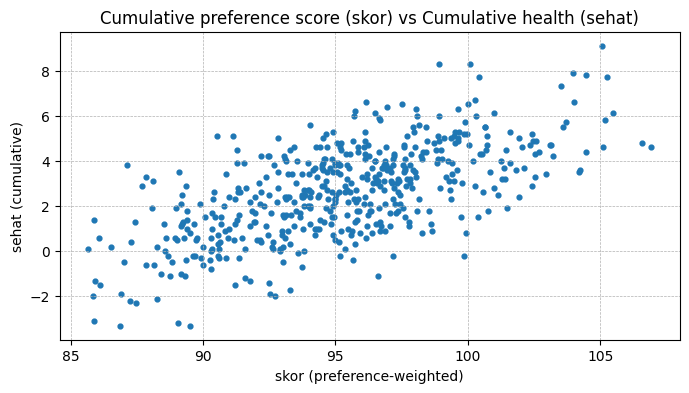

In [53]:
# Scatter Plot Preferensi Skor vs Kesehatan
plt.figure(figsize=(8,4))
plt.scatter(sim['skor'], sim['sehat'], s=12)
plt.title('Cumulative preference score (skor) vs Cumulative health (sehat)')
plt.xlabel('skor (preference-weighted)')
plt.ylabel('sehat (cumulative)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()


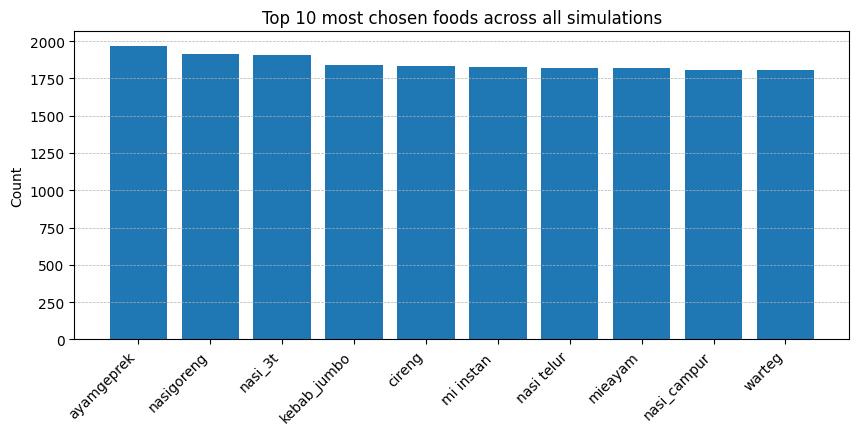

In [54]:
# Bar Chart Top 10 Makanan yang Sering Dipilih
all_choices = sim['resp_pilih'].flatten()
valid_choices = all_choices[all_choices >= 0]
if valid_choices.size == 0:
    print("No choices recorded.")
else:
    unique_choices_all, counts_all = np.unique(valid_choices, return_counts=True)
    choice_counts = pd.DataFrame({
        'food_idx': unique_choices_all.astype(int),
        'count': counts_all,
        'food_name': [makan['makanan'].iloc[int(i)] for i in unique_choices_all.astype(int)]
    }).sort_values('count', ascending=False).reset_index(drop=True)
    topn = min(10, len(choice_counts))
    plt.figure(figsize=(10,4))
    plt.bar(choice_counts['food_name'][:topn], choice_counts['count'][:topn])
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top {topn} most chosen foods across all simulations')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.show()


/tmp/ipython-input-509521484.py:1: RuntimeWarning: Mean of empty slice
  avg_sehat_per_bin = np.nanmean(sim['resp_sehat'], axis=0)


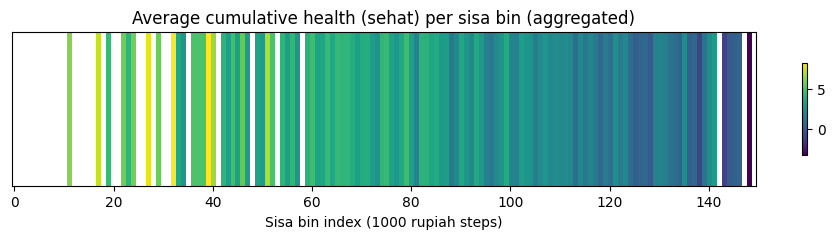

In [35]:
# Heatmap Average Kesehatan per Sisa bin
avg_sehat_per_bin = np.nanmean(sim['resp_sehat'], axis=0)
plt.figure(figsize=(12,2))
plt.imshow(avg_sehat_per_bin.reshape(1, -1), aspect='auto')
plt.yticks([])
plt.xlabel('Sisa bin index (1000 rupiah steps)')
plt.title('Average cumulative health (sehat) per sisa bin (aggregated)')
plt.colorbar(shrink=0.6)
plt.show()


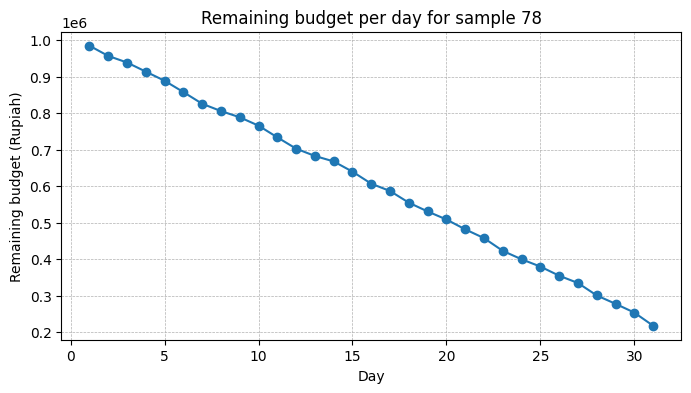

In [58]:
# Line Chart Budget yang Tersisa per Hari
if idx_max_skor is None or 'schedule_df' not in globals():
    print("Tidak ada schedule untuk plot remaining budget.")
else:
    plt.figure(figsize=(8,4))
    plt.plot(schedule_df['Day'], schedule_df['Remaining_budget_after_day'], marker='o')
    plt.title(f'Remaining budget per day for sample {idx_max_skor}')
    plt.xlabel('Day')
    plt.ylabel('Remaining budget (Rupiah)')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()


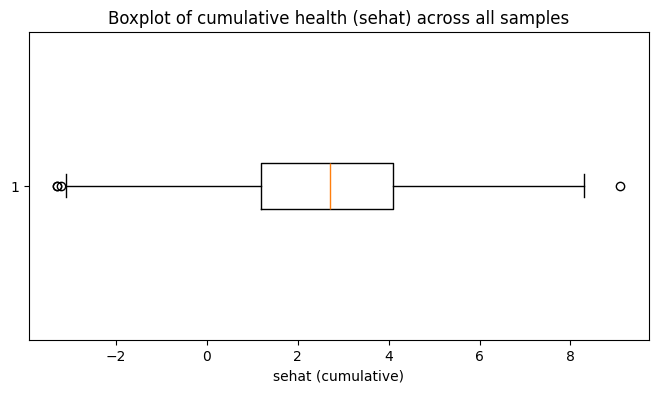

In [56]:
# Boxplot Kesehatan Kumulatif
plt.figure(figsize=(8,4))
plt.boxplot(sim['sehat'], vert=False)
plt.title('Boxplot of cumulative health (sehat) across all samples')
plt.xlabel('sehat (cumulative)')
plt.show()


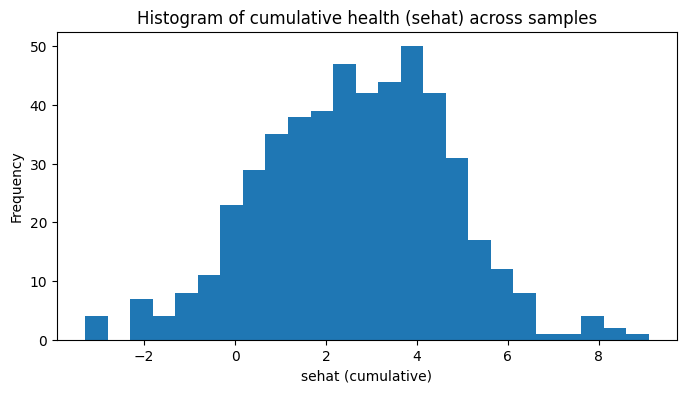

In [57]:
# Histogram Kesehatan Kumulatif
plt.figure(figsize=(8,4))
plt.hist(sim['sehat'], bins=25)
plt.title('Histogram of cumulative health (sehat) across samples')
plt.xlabel('sehat (cumulative)')
plt.ylabel('Frequency')
plt.show()


prompt:

> di bagian visualisasi data, visualisasinya jangan hanya terpaku pada 1 visual aja, buat juga alternatif visual lain yang mungkin bisa lebih cocok buat dipake di datanya

output yang diberikan adalah codescript untuk setiap visualisasi data di atas, seperti histogram, bar chart, line chart, scatter plot, heatmap, dan boxplot, menyesuaikan dengan kondisi data.